In [169]:

import cv2
from datetime import datetime
from pathlib import Path
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [174]:
T_SCALE = 0.002

TRAJECTORIES_CSV_DIR = Path("output/extracted_trajectories")
OUTPUT_BASE_DIR = Path("output/inspect_trajectory_hist")

trajectory_filepath = TRAJECTORIES_CSV_DIR / "_with_bboxes/3_classified_bb_sfc0/_with_bboxes/hn-bee-1_trajectories/9_bee_pts19606_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "_with_bboxes/3_classified_bb_sfc1/_with_bboxes/hn-bee-1_trajectories/9_bee_pts20400_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "_with_bboxes/3_classified_bb_sfc1_fixed/_with_bboxes/hn-bee-1_trajectories/9_bee_pts20400_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "_with_bboxes/3_classified_bb_sfc3/_with_bboxes/hn-bee-1_trajectories/9_bee_pts22105_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "_with_bboxes/3_classified_bb_sfc3_fixed/_with_bboxes/hn-bee-1_trajectories/9_bee_pts22106_start5289327.csv"

df3 = pd.read_csv(trajectory_filepath, sep=',', header="infer")
min_t = int(df3.t.min() / T_SCALE)
print("shifting t by " + str(min_t) + " us")
df3.t = (df3.t / T_SCALE - min_t).astype(int)
display(df3.head())
print("min t ", df3.t.min())

shifting t by -1274 us


,x,y,t,r,g,b,is_confident,bb_frame_index,bb_corner_index
0,765,504,1274,255,255,255,1,317,-1
1,765,505,1373,255,255,255,1,317,-1
2,764,504,1410,255,255,255,1,317,-1
3,764,504,1737,255,255,255,1,317,-1
4,764,508,1887,255,255,255,1,317,-1


min t  0


In [175]:
TIMEFRAME_US = 100 * 1000 # 100ms * 1000 -> 100.000us
WINDOW_INDEX = 9
WINDOWS = 1
WINDOW_START = WINDOW_INDEX * TIMEFRAME_US
WINDOW_END = (WINDOW_INDEX+1) * TIMEFRAME_US
# WINDOW_START = df3[df3.bb_corner_index==7].iloc[WINDOW_INDEX].t
# WINDOW_END = WINDOW_START + (TIMEFRAME_US * WINDOWS)
print("window index, start, end:", WINDOW_INDEX, WINDOW_START, WINDOW_END )

window_df = df3[(df3.t >= WINDOW_START-100) & (df3.t <= WINDOW_END+2000)]

display(window_df)

events_df = window_df.loc[window_df["bb_corner_index"].astype(int) == -1]
bb_events_df = window_df[window_df["bb_corner_index"].astype(int) >= 0]

# display(bb_events_df[bb_events_df.bb_corner_index==7].tail())

print((window_df.bb_corner_index == 0).sum())
print((window_df.bb_corner_index == 7).sum())

print("events:", len(events_df), "  bbox events:", len(bb_events_df))
print("window length", window_df.t.max() - window_df.t.min())
print("window start", window_df.t.min())

window index, start, end: 9 900000 1000000


,x,y,t,r,g,b,is_confident,bb_frame_index,bb_corner_index
9013,669,455,899918,255,255,255,1,370,-1
9014,668,458,899982,255,255,255,1,370,-1
9015,669,458,900043,255,255,255,1,370,-1
9016,669,457,900054,255,255,255,1,370,-1
9017,670,456,900068,255,255,255,1,370,-1
...,...,...,...,...,...,...,...,...,...
11304,621,430,1001956,255,255,255,1,377,-1
11637,609,416,1001440,127,255,212,0,377,0
11638,636,416,1001440,127,255,212,0,377,1
11639,609,443,1001440,127,255,212,0,377,2


7
7
events: 2236   bbox events: 56
window length 102038
window start 899918


In [176]:
bboxes = {} # frame, bbox points
for i,row in bb_events_df.iterrows():
    x = int(row["x"])
    y = int(row["y"])
    t = float(row["t"])
    fi = int(row["bb_frame_index"])
    corner = int(row["bb_corner_index"])
    if fi not in bboxes:
        bboxes[fi] = {}
    if corner >= 0:
        bboxes[fi][corner] = (x,y,t)

# for k,v in bboxes.items():
#     print(len(v), k,v)

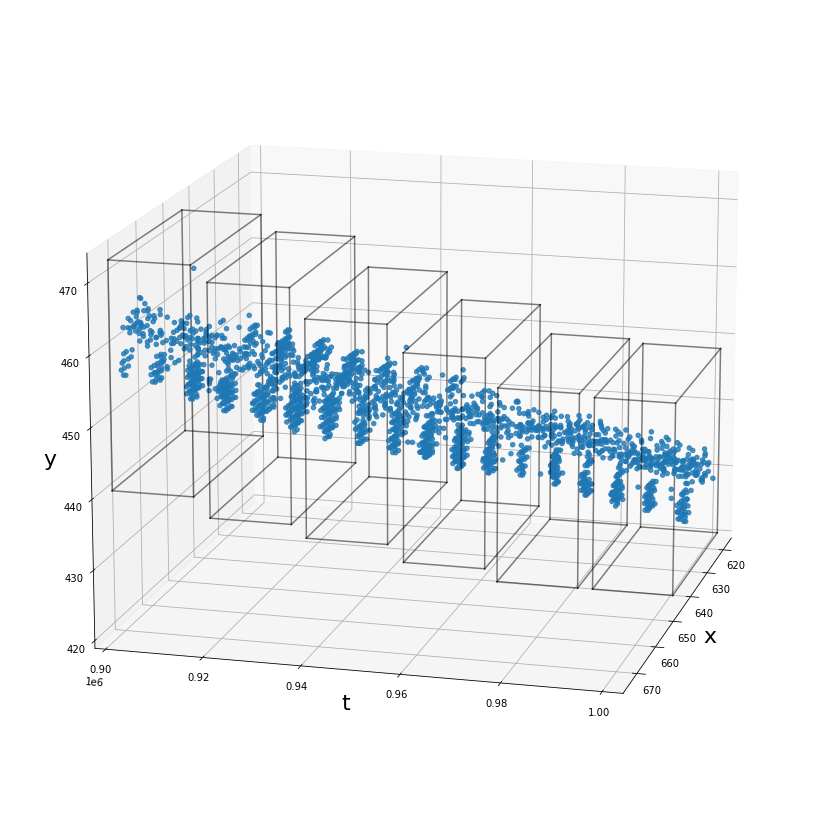

In [177]:
fig = plt.figure(figsize=(15,15))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d',computed_zorder=False)

# syntax for 3-D projection
x = events_df["x"]
y = events_df["y"]
t = events_df["t"]
c = events_df["bb_frame_index"].astype(int)
ax.scatter(x, t, y, alpha=0.8, cmap='cool', zorder=1)

# xx = np.array([0,1,0,1,0,1,0,1]) * 20 + 640
# tt = np.array([0,0,0,0,1,1,1,1]) * 20 + 100
# yy = np.array([0,0,1,1,0,0,1,1]) * 20 + 440

lines_start = [0,0,2,1,4,4,6,5,0,1,2,3]
lines_end =   [1,2,3,3,5,6,7,7,4,5,6,7]
lines_zorder= [2,2,2,2,0,0,0,0,0,0,1,1]
for k,bb in bboxes.items():
    if len(bb) != 8:
        continue
    for i in range(len(lines_start)):
        a = lines_start[i]
        b = lines_end[i]
        zo = lines_zorder[i]
        pointa = bb[a]
        pointb = bb[b]
        ax.plot([pointa[0],pointb[0]], [pointa[2],pointb[2]], [pointa[1],pointb[1]], color='black', alpha=0.5, zorder=zo)

# syntax for plotting
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('t', fontsize=22)
ax.set_zlabel('y', fontsize=22)
ax.elev = 15
ax.azim = 15
# ax.axis('off')
ax.margins(0)
plt.show()
